In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from biokit.viz import corrplot

In [2]:
# Load five data sets of five boroughs in New York City. The datasets also uploaded to Github
list = ["SI", "QN", "MN", "BX", "BK"]
nydata = []
for i in list:
    url = "PLUTO17v1.1/" + i +"2017V11.csv"
    nydata.append(pd.read_csv(url))
nydata = pd.concat(nydata)

C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,24,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  i

In [3]:
# Check the counts of values for each borough
nydata.Borough.value_counts()

QN    324584
BK    277485
SI    124240
BX     89870
MN     43044
Name: Borough, dtype: int64

In [6]:
# The objective of first EDA is to predict the total value of lot "AssessTot" (builidng value + land value)
# By checking the data dictionary, find 12 dependent variables that are possibly important based on domain knowledge

cols = ["AssessTot", "AssessLand", "LotArea", "BldgArea","ComArea", "ResArea", "OfficeArea","RetailArea","GarageArea",
        "StrgeArea", "FactryArea", "ExemptLand"]

Computing correlation


C:\Users\zhengy\AppData\Local\Continuum\anaconda3\lib\site-packages\biokit\viz\linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


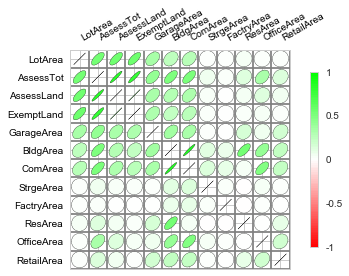

In [74]:
# Plot the correlation plot and filter out the irrelevant ones
c = corrplot.Corrplot(nydata[cols])
c.plot(cmap=('red', 'white', 'green'))

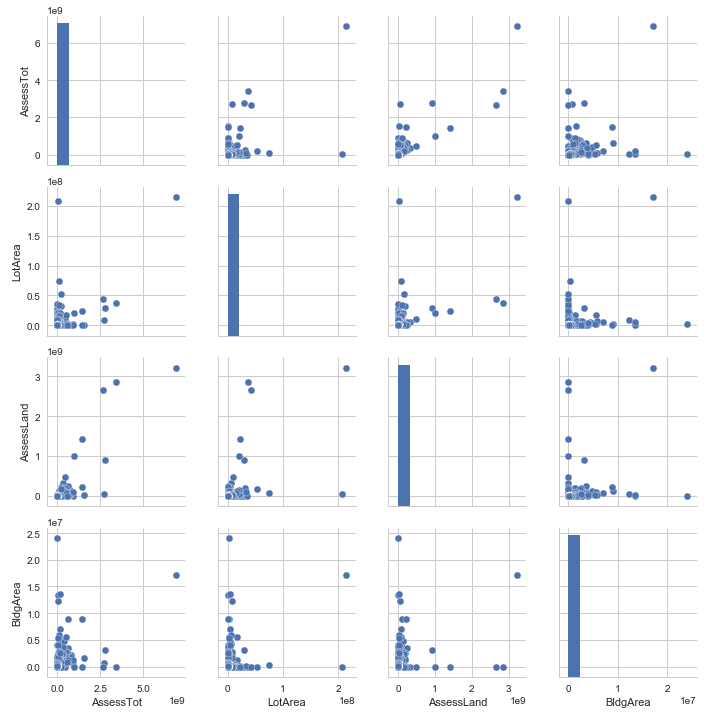

In [7]:
# Further plot the pairplot to examine the relationship between "AssessTot" and high-level variables
col_overall = ["AssessTot", "LotArea", "AssessLand", "BldgArea"]
sns.set(style="whitegrid", context="notebook")
sns.pairplot(nydata[col_overall], size=2.5)
plt.show()

# It can be seen there exist some linear relationships

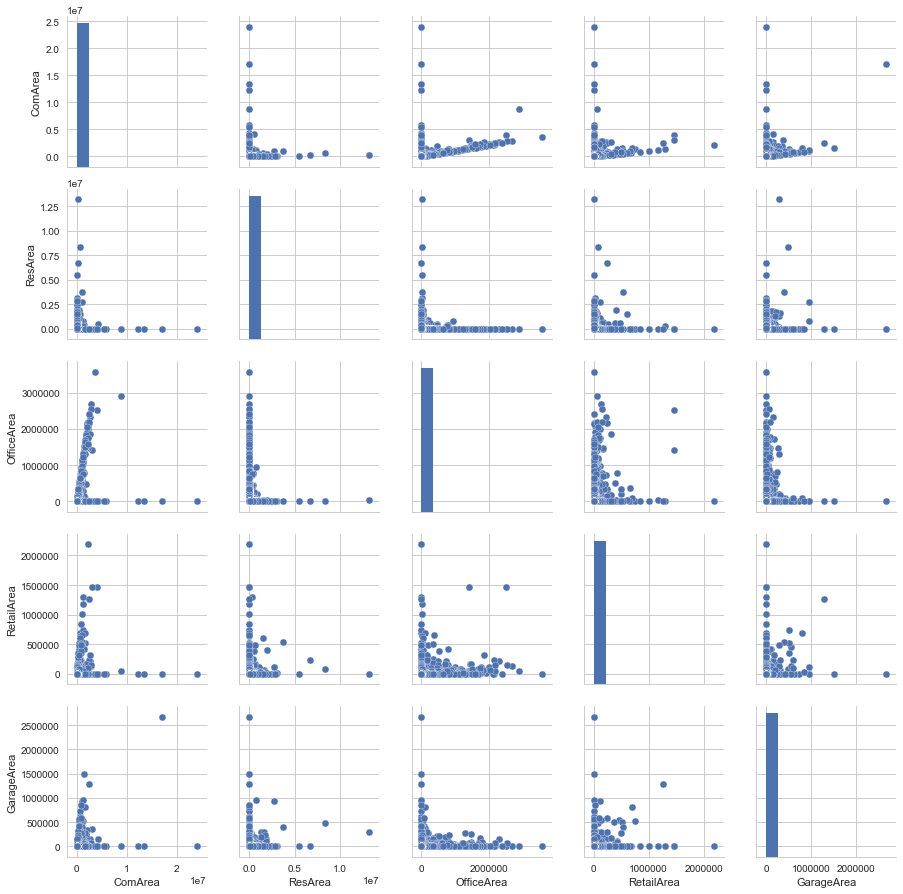

In [8]:
# Then plot the pairplot to examine the relationship between "AssessTot" and low-level variables
cols_detail =["ComArea", "ResArea", "OfficeArea","RetailArea","GarageArea"]
sns.set(style="whitegrid", context="notebook")
sns.pairplot(nydata[cols_detail], size=2.5)
plt.show()

# It can be seen there exist some linear relationships

In [5]:
'''Since the above variables are all correlated to the dependent variable "AssessTot" somehow, first fit regression
model to explore relationship. 
'''

r_cols = ["LotArea", "AssessLand", "BldgArea","ComArea", "ResArea", "OfficeArea","RetailArea","GarageArea"]
X = nydata[r_cols].values
y = nydata['AssessTot'].values

# Standardize X and y using StandardScaler from sklearn. 
from sklearn.preprocessing import StandardScaler

sd_x = StandardScaler()
sd_y = StandardScaler()
X_std = sd_x.fit_transform(X)
y_std = sd_y.fit_transform(y[:, np.newaxis]).flatten()

C:\Users\fanfan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# Split data into training set and test set using train_test_split from sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.3, random_state=20)

In [41]:
# Fit linear regression model using LinearRegression() from sklearn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# Print the coefficients of explanatory variables of the linear model fitted by the training set
for i in range(len(r_cols)):
    print (r_cols[i] + ": %.10f" % lr.coef_[i])

# Use the fitted model to predict the y of the test set 
y_lr_test_pred = lr.predict(X_test)
y_lr_train_pred = lr.predict(X_train)

LotArea: 0.1738770236
AssessLand: 0.6353189806
BldgArea: 0.4389649771
ComArea: -0.1495278586
ResArea: -0.1522704792
OfficeArea: 0.1308454730
RetailArea: 0.0040573538
GarageArea: 0.0635707141


In [8]:
# Evaluate the performance of model using R-squared to check how much variance of dependent variable can be explained

from sklearn.metrics import r2_score

# Calculate the R squared for the test set
r2_lr_test = r2_score(y_test, y_lr_test_pred)

# Calcuate the R squared for the training set
r2_lr_train = r2_score(y_train, y_lr_train_pred)

print ("Linear regression R squared train: %.10f" % r2_score(y_train, y_lr_train_pred))
print ("Linear regression R squared test: %.10f" % r2_score(y_test, y_lr_test_pred))

# It can be seen that r2_lr_traing is a little higher than r2_lr_test, the model is slightly overfit.

Linear regression R squared train: 0.7958503734
Linear regression R squared test: 0.7519017617


In [9]:
# Add regulariation to reduce overfitting. First try the Lasso to add L1 norm to reduce the coefficient

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_lasso_train_pred = lasso.predict(X_train)
y_lasso_test_pred = lasso.predict(X_test)
for i in range(len(r_cols)):
    print (r_cols[i] + ": %.10f" % lasso.coef_[i])

LotArea: 0.0830436398
AssessLand: 0.6294544830
BldgArea: 0.1126646360
ComArea: 0.1180439290
ResArea: 0.0000000000
OfficeArea: 0.0349410214
RetailArea: 0.0000000000
GarageArea: 0.0297562156


In [10]:
print ("Lasso R squared train: %.10f" % r2_score(y_train, y_lasso_train_pred))
print ("Lasso R squared test: %.10f" % r2_score(y_test, y_lasso_test_pred))


# It can be seen the overfitting is reduced by adding regulization to the linear model

Lasso R squared train: 0.7743807961
Lasso R squared test: 0.7736384133


In [56]:
# Examine the effects of different hyperparameter alpha onto the coefficients
colors = ['blue', 'green', 'red', 'yellow', 'black', 'magenta', 'pink', 'orange']
weights = []
alpha = [0,0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]
for c in alpha:
    lasso = Lasso(alpha=c)
    lasso.fit(X_train, y_train)
    weights.append(lasso.coef_)

C:\Users\fanfan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\fanfan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\fanfan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


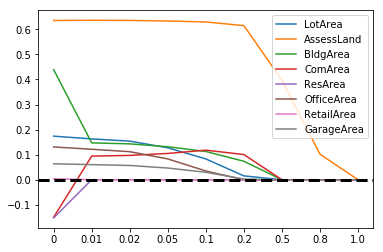

In [57]:
# Plot the changes of hyperprameter alpha and corresponding changes of the coefficients 
plt.plot(weights)
plt.legend(r_cols)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xticks(np.arange(len(alpha)), alpha)
plt.show()

In [16]:
'''
The R squared values for simple linear regression and Lasso is not very high. It is possibly because there are outliers.
Snice the outliers may contain interesting information. I would like to explore how to deal with these outliers in 
Data Incubator program instead of simply removing them. Also, I would like to futher try some robust models such as 
RANdom SAmple Consensus(RANSAC) and Random Forest Regression to reduce the effects of outliers. 

'''
